In [1]:
from datetime import datetime, timedelta
import json
from math import ceil
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append('..')
from models.qp.qpercent import QPercent
from util.batcher import Batcher
from util.stock_loader import Loader

In [2]:
!ls ../models/qp

__pycache__ qpercent.py


In [3]:
SD = 0.05 * (0.8 ** 1) # -4 ... 10 
print('SD:', SD)

SD: 0.04000000000000001


In [4]:
DATA = '../models/qp/data'
SYMBOLS = [
    'ABMD', 'ABNB', 'ANET', 'ATVI', 'AXON', 'AYX', 'BILI', 'BYND', 'COUR', 'CPNG', 'DDOG', 
    'DOCU', 'EDIT', 'ETSY', 'FSLY', 'FUV', 'GH', 'GMED', 'INTG', 'ISRG', 'JD', 'LULU', 
    'LUV', 'MDB', 'MELI', 'MNST', 'MTCH', 'NVCR', 'OKTA', 'PANW', 'PINS', 'PTON', 'QDEL', 
    'RDFN', 'RGEN', 'ROKU', 'SE', 'SHOP', 'TDOC', 'TEAM', 'TREX', 'TTD', 'TTWO', 'TWLO', 
    'TWTR', 'VEEV', 'ZEN', 'ZG', 'ZNGA']
INDICES = ['^GSPC', # S&P 500
           '^IXIC', # Nasdaq
           '^NYA']  # NY Stock Exchange (total)
len(SYMBOLS)

49

In [5]:
N_YEARS = 50
N_CUTS = 10
N_DAYS = int(round(365.25 * N_YEARS))
TODAY = datetime.now().date()
START = '1978-07-26' #str(TODAY - timedelta(N_DAYS))
START, TODAY

('1978-07-26', datetime.date(2021, 6, 29))

In [6]:
batcher = Batcher(SYMBOLS, INDICES)
batch = batcher.get_batch_from_weekday(TODAY.weekday())
batch

['BYND', 'COUR', 'CPNG', 'DDOG', 'DOCU', 'EDIT', 'ETSY', '^IXIC']

In [7]:
stock_loader = Loader(batch, START, verbose=True)
data = stock_loader.download()

[*********************100%***********************]  8 of 8 completed
Generating derived columns...
   ...BYND
   ...COUR
   ...CPNG
   ...DDOG
   ...DOCU
   ...EDIT
   ...ETSY
   ...^IXIC


In [8]:
def get_stock_data(stock, data):
    sub = data.loc[:,  [x for x in list(data) if x[1] == stock or x[0] == 'Date']]
    first_value = sub.Value[stock][sub.Value[stock].notna()].index[0]
    sub = sub.loc[first_value:, :]
    sub.index = range(sub.shape[0])
    sub.columns = sub.columns.to_series().apply(lambda x: x[0])
    return sub

In [9]:
def str_to_tuple(s):
    s = s[1:-1]
    return tuple([float(x) for x in s.split(', ')])

str_to_tuple('(0.123, 0.456)')

(0.123, 0.456)

In [10]:
def read_best_params(stock):
    try:
        with open(f'{DATA}/{stock}_best.json', 'r') as f:
            params = json.load(f)
        for k in params:
            params[k]['q_params'] = {str_to_tuple(k): v for k, v in params[k]['q_params'].items()}
        best_returns = {k: params[k]['best_return'] for k in params}
        print('Loaded current best.')
        return params, best_returns
    except FileNotFoundError:
        print('No saved data. Initialized as None')
        return None, None
    except:
        print(f'Unexpected error getting {stock} data.  Initialized as None.')

In [11]:
def get_best_param_set(qp):
    best_param_set = qp.best_param_set
    for method in best_param_set:
        best_param_set[method]['best_return'] = qp.best_returns[method]
        # stringify tuple keys:
        best_param_set[method]['q_params'] = {str(k): v for k, v in best_param_set[method]['q_params'].items()}
    return best_param_set

In [12]:
def save_best_param_set(best_param_set, stock):
    print(f'Saving {stock} params...')
    with open(f'{DATA}/{stock}_best.json', 'w') as f:
        json.dump(best_param_set, f)

In [13]:
if TODAY.weekday() == 0:
    !say update standard deviation




----------------------------------------------------------------------
                                 BYND
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 1.0684874804003306
Refitting current best...
Current best ma returns: 2.1432097823824816
Fraction Invested: 0.0014132780031408795
Beginning random search...
Round: 5
Beginning adjusted search...
New best: 2.143212356342633
Invested: 0.0014132780031408795
New best: 2.1439023392976315
Invested: 0.0014132780031408795
New best: 2.306371098323787
Invested: 0.0014132780031408795
New best: 2.3622965402480585
Invested: 0.0014132780031408795
New best: 2.363084679729328
Invested: 0.0014132780031408795
New best: 2.3653979318857603
Invested: 0.0014132780031408795
New best: 2.3659313787170326
Invested: 0.0014132780031408795
New best: 2.4591576288520938
Invested: 0.0014132780031408795
New best: 2.45924953

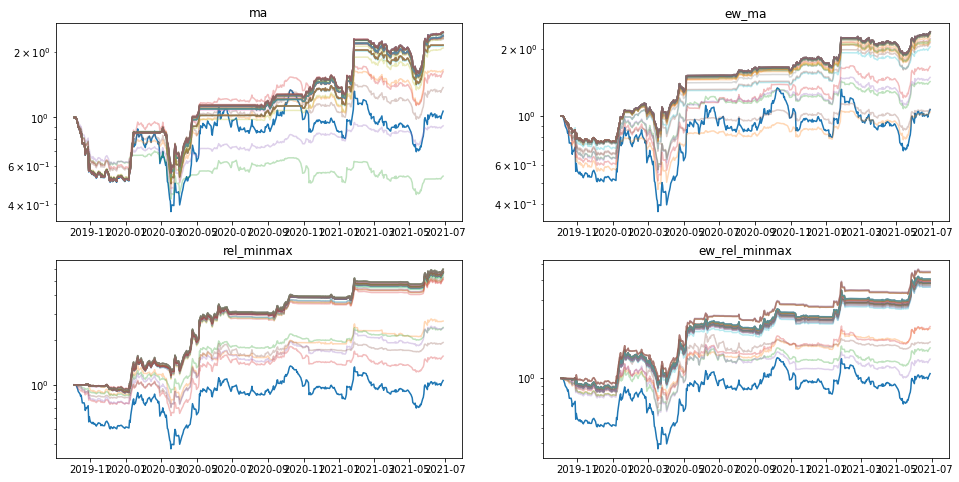

Saving BYND params...



----------------------------------------------------------------------
                                 COUR
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 0.9973859171681313
Refitting current best...
Current best ma returns: 1.078814735073105
Fraction Invested: 0.27557872569539416
Beginning random search...
Round: 5
Beginning adjusted search...
New best: 1.081182080800513
Invested: 0.4429090602207965
New best: 1.0924893424953923
Invested: 0.4429090602207965
New best: 1.097883122812735
Invested: 0.4429090602207965
New best: 1.0979043703513456
Invested: 0.4429090602207965
New best: 1.0979249023544007
Invested: 0.4429090602207965
New best: 1.0987859202883237
Invested: 0.4429090602207965
New best: 1.0992911567747021
Invested: 0.4429090602207965
New best: 1.0996825524488127
Invested: 0.4429090602207965
New best: 1.099729499375

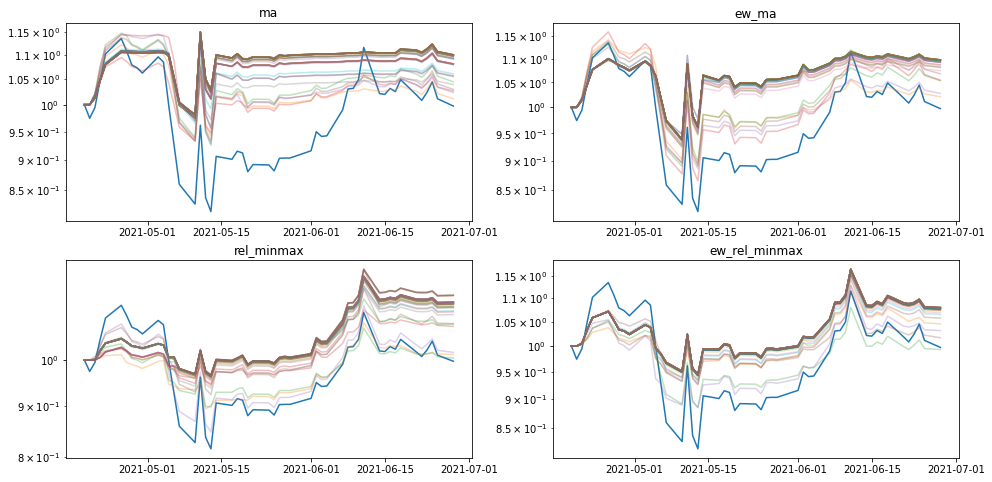

Saving COUR params...



----------------------------------------------------------------------
                                 CPNG
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 0.8084971230120094
Refitting current best...
Current best ma returns: 0.9604677234198595
Fraction Invested: 0.4116390630530509
Beginning random search...
New best: 0.967247892380747
Invested: 0.3963386771900491
Round: 5
Beginning adjusted search...
New best: 0.9676969676182793
Invested: 0.3963386771900491
New best: 0.9676984772397023
Invested: 0.3963386771900491
New best: 0.9689036783224185
Invested: 0.3963386771900491
New best: 0.9700349096239472
Invested: 0.3963386771900491
New best: 0.9719881757723988
Invested: 0.3963386771900491
New best: 0.9748848691539832
Invested: 0.3963386771900491
New best: 0.9749870599819862
Invested: 0.3963386771900491
New best: 0.97888991221

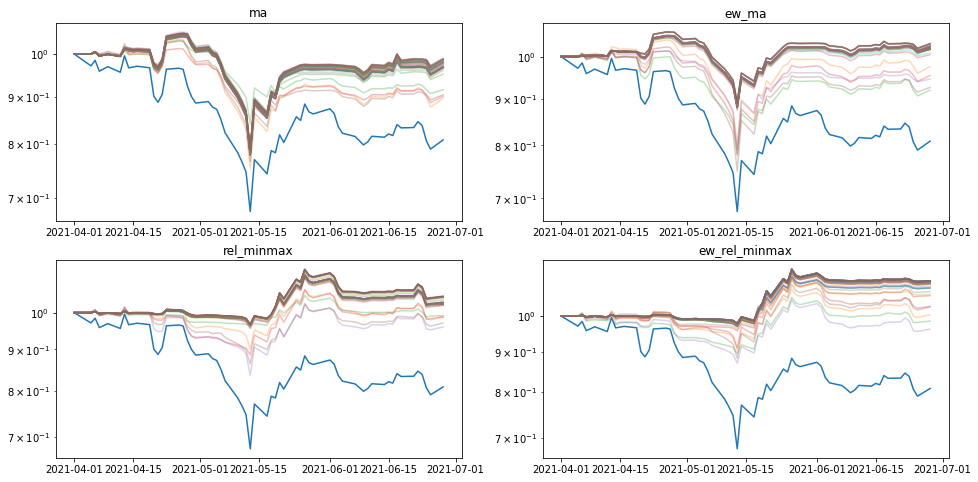

Saving CPNG params...



----------------------------------------------------------------------
                                 DDOG
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 2.524667998734346
Refitting current best...
Current best ma returns: 2.446095189430269
Fraction Invested: 0.9928143424426107
Beginning random search...
Round: 5
Beginning adjusted search...
New best: 2.446151251116183
Invested: 0.9928143424426107
New best: 2.4465580558178557
Invested: 0.9928143424426107
New best: 2.447289572679481
Invested: 0.9928143424426107
New best: 2.447305377960373
Invested: 0.9928143424426107
New best: 2.448160502216179
Invested: 0.9928143424426107
New best: 2.448184376438025
Invested: 0.9928143424426107
New best: 2.4481889116264575
Invested: 0.9928143424426107
New best: 2.448429585865883
Invested: 0.9928143424426107
New best: 2.45348018744783
Inv

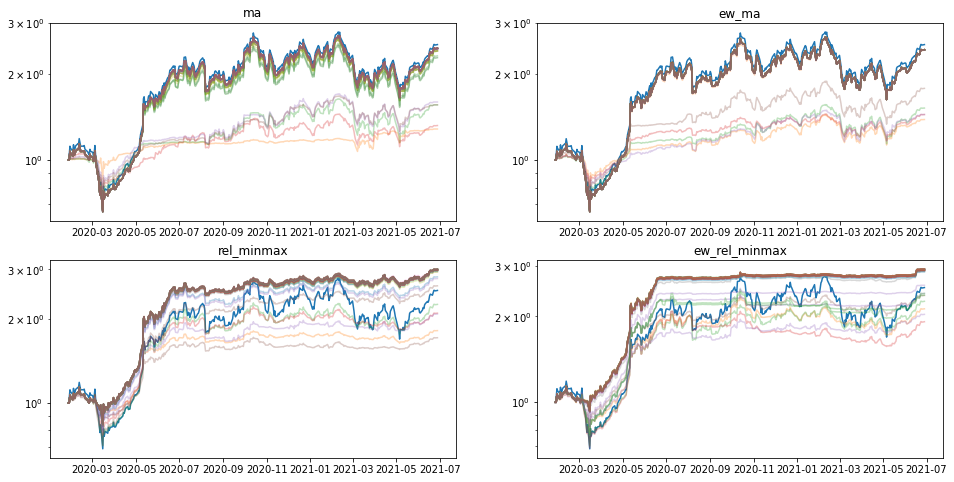

Saving DDOG params...



----------------------------------------------------------------------
                                 DOCU
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 6.585167644225168
Refitting current best...
Current best ma returns: 7.690464486824729
Fraction Invested: 0.994987645892004
Beginning random search...
Round: 5
Beginning adjusted search...
New best: 7.690556958961473
Invested: 0.994987645892004
New best: 7.701724805419331
Invested: 0.994987645892004
New best: 7.702113838684231
Invested: 0.994987645892004
Round: 50


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 6.585167644225168
Refitting current best...
Current best ew_ma returns: 9.105557581589435
Fraction Invested: 0.9977507897197458
Beginning random search...
Round: 5
Beginning adjusted search...
New best: 9.1060676

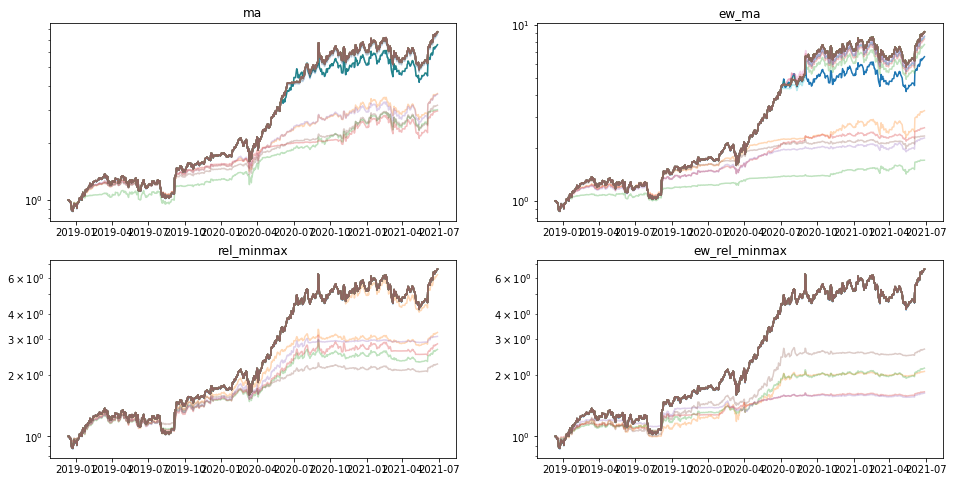

Saving DOCU params...



----------------------------------------------------------------------
                                 EDIT
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 1.9977293716611655
Refitting current best...
Current best ma returns: 3.7607247709938822
Fraction Invested: 0.49680191730295586
Beginning random search...
Round: 5
Beginning adjusted search...
New best: 3.767684150825059
Invested: 0.49680191730295586
New best: 3.772587087289453
Invested: 0.49680191730295586
New best: 3.784245972453231
Invested: 0.49680191730295586
New best: 3.844600804792459
Invested: 0.49680191730295586
New best: 3.844611946052707
Invested: 0.49680191730295586
New best: 3.8459316344778305
Invested: 0.49680191730295586
Round: 50


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 1.9977293716611655
Refittin

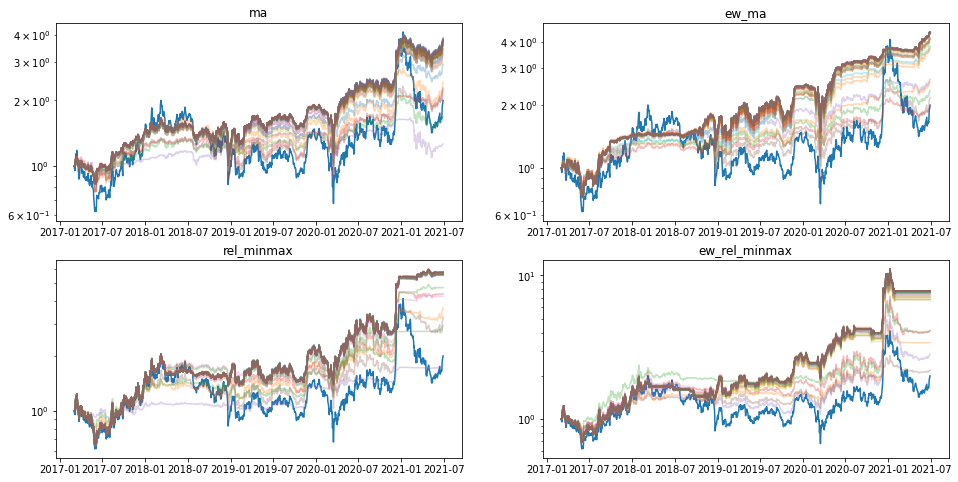

Saving EDIT params...



----------------------------------------------------------------------
                                 ETSY
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 19.45196150708594
Refitting current best...
Current best ma returns: 20.257974588684778
Fraction Invested: 0.9989839174868669
Beginning random search...
Round: 5
Beginning adjusted search...
New best: 20.261737599063494
Invested: 0.9989839174868669
New best: 20.262390257607535
Invested: 0.9989839174868669
New best: 20.26313687488071
Invested: 0.9989839174868669
New best: 20.264598062937242
Invested: 0.9989839174868669
New best: 20.410964594405158
Invested: 0.9989839174868669
New best: 20.41291190268595
Invested: 0.9989839174868669
New best: 20.413278662070425
Invested: 0.9989839174868669
New best: 20.414049344882933
Invested: 0.9989839174868669
New best: 20.420618424879

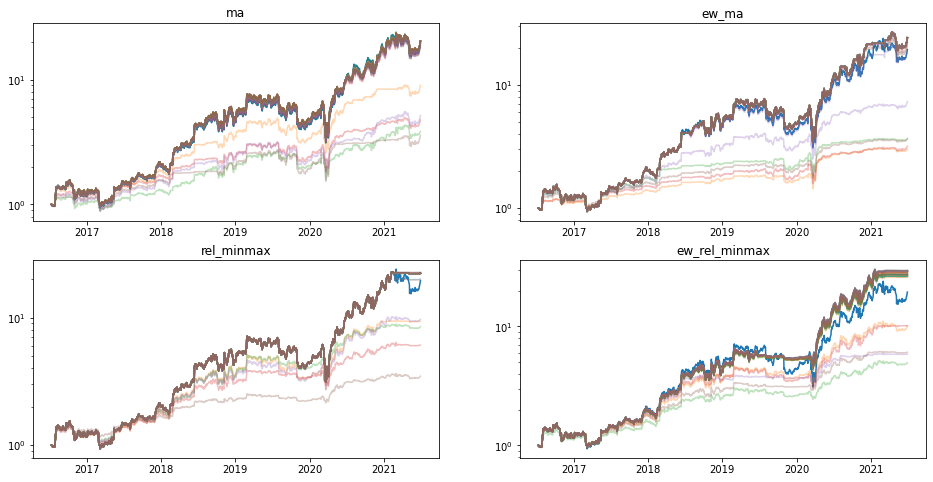

Saving ETSY params...



----------------------------------------------------------------------
                                 ^IXIC
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 34.76506725829746
Refitting current best...
Current best ma returns: 44.40940260291103
Fraction Invested: 0.9940045956789944
Beginning random search...
Round: 5
Beginning adjusted search...
New best: 44.40971489520228
Invested: 0.9940102097929278
New best: 44.40971632614628
Invested: 0.9940102097929278
Round: 50


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 34.76506725829746
Refitting current best...
Current best ew_ma returns: 42.867500723819916
Fraction Invested: 0.994672157936413
Beginning random search...
Round: 5
Beginning adjusted search...
New best: 42.867531456343094
Invested: 0.994672157936413
New best: 42.8

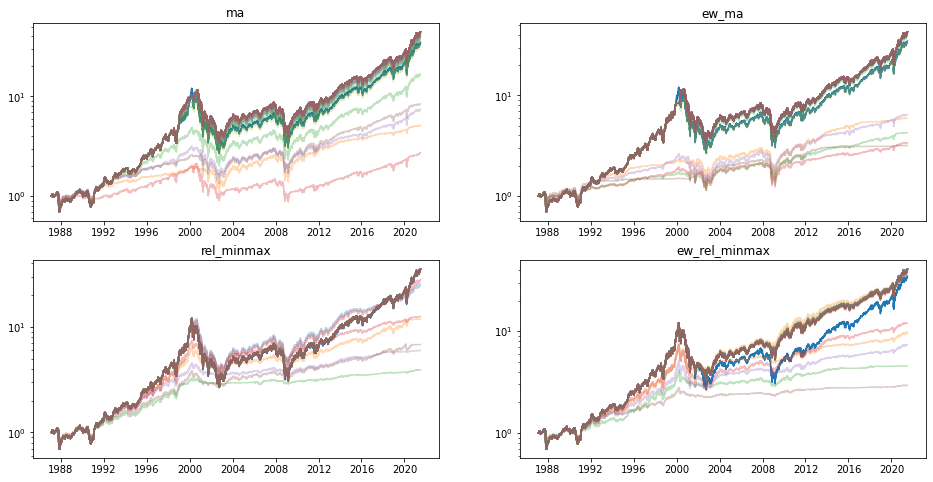

Saving ^IXIC params...


In [16]:
N_RAND = 5
N_ADJ = 50

for stock in batch:
    print('\n\n')
    print('-' * 70)
    print(' ' * 32, stock)
    print('-' * 70)
    best_params, best_returns = read_best_params(stock)
    stock_data = get_stock_data(stock, data)
    qp = QPercent(stock_data, N_CUTS, best_param_set=best_params, best_returns=best_returns, sd=SD)
    qp.run_sims(N_RAND, N_ADJ)
    best = get_best_param_set(qp)
    save_best_param_set(best, stock)

In [17]:
def get_summary(stocks):
    for stock in stocks:
        try:
            with open(f'{DATA}/{stock}_best.json', 'r') as f:
                best = json.load(f)
            best_method = None
            best_return = 0
            best_pct = None
            for key in best:
                ret = best[key]['best_return']
                if ret > best_return:
                    best_return = ret
                    best_method = key
                    best_pct = best[key]['pct']
            print(f'\n{stock}:\n  Best Return: {best_return} ({best_method})\n  {100 * best_pct:.2f}% in')
        except FileNotFoundError:
            continue

In [18]:
get_summary(SYMBOLS + INDICES)


ABMD:
  Best Return: 464.20851017152904 (rel_minmax)
  43.18% in

ABNB:
  Best Return: 1.084508663599577 (rel_minmax)
  45.13% in

ANET:
  Best Return: 8.561156290812194 (rel_minmax)
  99.38% in

ATVI:
  Best Return: 225.6217350040542 (ew_ma)
  99.86% in

AXON:
  Best Return: 26.009869424852184 (ma)
  74.35% in

AYX:
  Best Return: 10.267822845876552 (ma)
  99.97% in

BILI:
  Best Return: 12.959506419505866 (rel_minmax)
  99.30% in

BYND:
  Best Return: 5.99625381796733 (rel_minmax)
  92.10% in

COUR:
  Best Return: 1.161491872818395 (rel_minmax)
  0.07% in

CPNG:
  Best Return: 1.1093215534352812 (ew_rel_minmax)
  16.11% in

DDOG:
  Best Return: 3.007824587919802 (rel_minmax)
  27.65% in

DOCU:
  Best Return: 9.107298989556774 (ew_ma)
  99.78% in

EDIT:
  Best Return: 7.803948750354289 (ew_rel_minmax)
  1.00% in

ETSY:
  Best Return: 29.493814717015137 (ew_rel_minmax)
  0.74% in

FSLY:
  Best Return: 6.552982415936774 (rel_minmax)
  93.14% in

FUV:
  Best Return: 10.763500320398348 (

In [ ]:
!say qp is dunzo